In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data_preprocessing import timepoint_split, transform_indices, reindex_data, generate_weights
from evaluation import model_evaluate, topn_recommendations

%config InlineBackend.figure_format = "svg"
plt.rcParams["figure.figsize"] = 10, 6

## MovieLens-1M

In [3]:
# !mkdir data
# !wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
# !unzip ml-1m.zip -d data

In [55]:
movielens = pd.read_csv("data/ml-1m/ratings.dat", sep="::", names=["userid", "itemid", "rating", "timestamp"], engine="python")

In [56]:
movielens.nunique()

userid         6040
itemid         3706
rating            5
timestamp    458455
dtype: int64

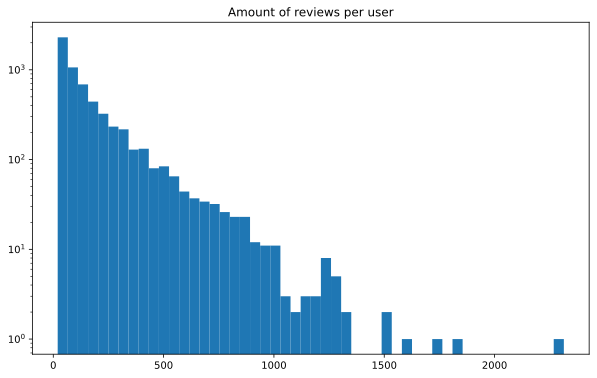

In [57]:
plt.hist(movielens.groupby("userid").size(), bins=50)
plt.yscale("log")
plt.title("Amount of reviews per user")
plt.show()

In [58]:
# Split for final evaluation
_train, _test, _holdout = timepoint_split(movielens, time_split_q=0.95)

len(_train), len(_test), len(_holdout)

(725370, 221697, 802)

In [59]:
# Additional split for hyperparameter tuning
_trainval, _testval, _holdoutval = timepoint_split(_train, time_split_q=0.95)

len(_trainval), len(_testval), len(_holdoutval)

(611093, 77989, 407)

In [60]:
def reindex_all(train, test, holdout=None, userid='userid', itemid='itemid'):
    train_new, data_index = transform_indices(train, userid, itemid)
    test_new = reindex_data(test, data_index, fields='items')
    
    if holdout is None:
        return train_new, test_new, data_index
    
    holdout_new = reindex_data(holdout, data_index, fields='items')
    return train_new, test_new, holdout_new, data_index


trainval, testval, holdoutval, data_index_val = reindex_all(_trainval, _testval, _holdoutval)

In [61]:
data_description = {
    "n_users": trainval.userid.nunique(),
    "n_items": trainval.itemid.nunique(),
    "feedback": "rating",
    "weights": "weights",
    "items": "itemid",
    "users": "userid",
}

trainval = generate_weights(trainval, data_description)
testval = generate_weights(testval, data_description)

## Popular

In [11]:
topn = 20

In [12]:
alphas = [2 ** p for p in range(12)]

popular_results = []

for a in alphas:
    def damped_mean(ratings):
        return sum(ratings) / (len(ratings) + a)
    
    item2rating = trainval.groupby('itemid')["rating"].apply(damped_mean)
    best_items = item2rating.nlargest(topn).index.values
    popular_recs = np.ones((len(holdoutval), topn)) * best_items
    metric = model_evaluate(popular_recs, holdoutval, data_description, topn)    
    
    popular_results.append({
        "alpha": a, "metric": metric
    })

popular_results = pd.DataFrame(popular_results)

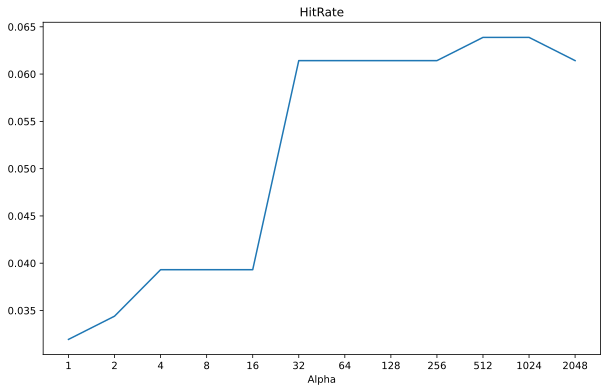

In [13]:
plt.plot(popular_results["alpha"], popular_results["metric"])
plt.xscale("log")
plt.xticks(popular_results["alpha"], popular_results["alpha"])
plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("Alpha")

plt.show()

## Pure SVD

In [14]:
from pure_svd import build_svd_model, svd_scoring, svd_gridsearch

In [15]:
ranks = [b * 2 ** p for p in range(0, 7) for b in [2, 3]]
ranks

[2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192]

In [16]:
results = svd_gridsearch(ranks, trainval, testval, holdoutval, data_description, topn)

results = pd.DataFrame(results)

Interaction matrix shape: (4662, 3630)
Matrix density: 0.03611007701916793


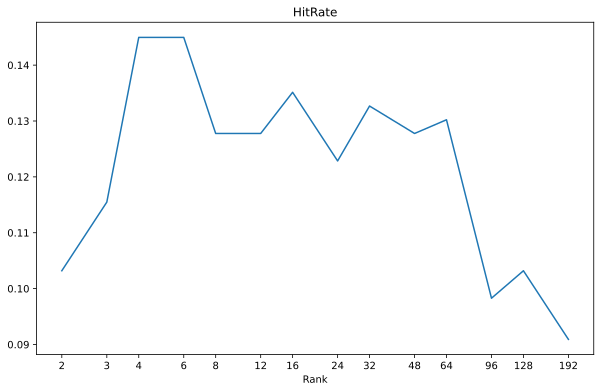

In [17]:
plt.plot(results["rank"], results["metric"])
plt.xscale("log")
plt.xticks(results["rank"], results["rank"])
plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("Rank")

plt.show()

In [18]:
best_rank = results.sort_values("metric")["rank"].iloc[-1]
print("Best rank:", best_rank)

model = build_svd_model({"rank": best_rank}, trainval, data_description)
scores = svd_scoring(model, testval, data_description)
svd_recs = topn_recommendations(scores, topn)

Best rank: 6
Interaction matrix shape: (4662, 3630)
Matrix density: 0.03611007701916793


In [19]:
print("HitRate:", model_evaluate(svd_recs, holdoutval, data_description, topn))

HitRate: 0.14496314496314497


## Scaled SVD

In [20]:
from scaled_svd import build_scaled_svd_model, scaled_svd_gridsearch

In [21]:
ranks = [b * 2 ** p for p in range(0, 7) for b in [2, 3]]
ranks

[2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192]

In [22]:
scalings = np.arange(1, 10, 2) / 10
scalings

array([0.1, 0.3, 0.5, 0.7, 0.9])

In [23]:
results = scaled_svd_gridsearch(ranks, scalings, trainval, testval, holdoutval, data_description, topn)

Scaling 0.1
Scaling 0.3
Scaling 0.5
Scaling 0.7
Scaling 0.9


In [24]:
results = pd.DataFrame(results)

results = results.sort_values("metric", ascending=False)

results.head()

,rank,scaling,metric
30,4,0.5,0.154791
44,4,0.7,0.154791
17,6,0.3,0.152334
27,192,0.3,0.152334
18,8,0.3,0.152334


## SeqSVD

In [25]:
from seq_svd import full_seq_svd_gridsearch, build_seq_svd_model

In [26]:
ranks = [b * 2 ** p for p in range(0, 5) for b in [2, 3]]
ranks

[2, 3, 4, 6, 8, 12, 16, 24, 32, 48]

In [30]:
coefs = [0.25, 0.5, 0.75]
thresholds = [0.003, 0.03] 
powers = [1, 0.75]
sim_types = ["cosine"]
scalings = np.arange(1, 10, 2) / 10
scalings

array([0.1, 0.3, 0.5, 0.7, 0.9])

In [31]:
seq_svd_results = full_seq_svd_gridsearch(ranks, coefs, powers, thresholds, sim_types, scalings,
                                          trainval, testval, holdoutval, data_description, topn)

Sequence similarity coef: 0.25, power: 1, threshold: 0.003, similarity type: cosine, scaling: 0.1
Sequence similarity coef: 0.25, power: 1, threshold: 0.003, similarity type: cosine, scaling: 0.3
Sequence similarity coef: 0.25, power: 1, threshold: 0.003, similarity type: cosine, scaling: 0.5
Sequence similarity coef: 0.25, power: 1, threshold: 0.003, similarity type: cosine, scaling: 0.7
Sequence similarity coef: 0.25, power: 1, threshold: 0.003, similarity type: cosine, scaling: 0.9
Sequence similarity coef: 0.25, power: 1, threshold: 0.03, similarity type: cosine, scaling: 0.1
Sequence similarity coef: 0.25, power: 1, threshold: 0.03, similarity type: cosine, scaling: 0.3
Sequence similarity coef: 0.25, power: 1, threshold: 0.03, similarity type: cosine, scaling: 0.5
Sequence similarity coef: 0.25, power: 1, threshold: 0.03, similarity type: cosine, scaling: 0.7
Sequence similarity coef: 0.25, power: 1, threshold: 0.03, similarity type: cosine, scaling: 0.9
Sequence similarity coef:

In [34]:
seq_svd_results = pd.DataFrame(seq_svd_results)

seq_svd_results = seq_svd_results.sort_values("metric", ascending=False)

In [35]:
seq_svd_results.head()

,rank,incomplete_cholesky_threshold,sequence_similarity_coef,similarity_type,power,scaling,metric
102,4,0.003,0.25,cosine,0.75,0.1,0.203931
2,4,0.003,0.25,cosine,1.00,0.1,0.194103
253,6,0.030,0.50,cosine,1.00,0.1,0.189189
51,3,0.030,0.25,cosine,1.00,0.1,0.189189
312,4,0.003,0.50,cosine,0.75,0.3,0.186732


## UserKNN

In [62]:
from knn import uknn_gridsearch, build_uknn_model, uknn_scoring

In [63]:
k_vals = [10, 25, 50, 100, 200, 250, 500, 1000, 1500, 2000]
#a_vals = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
a_vals = [0, 0.2, 0.5, 0.8, 1]

config = {
    'weights': False
}

In [64]:
%%time
results = uknn_gridsearch(k_vals, a_vals, config, trainval, testval, holdoutval, data_description, topn=20)

CPU times: user 13.8 s, sys: 40.4 ms, total: 13.8 s
Wall time: 13.8 s


In [65]:
knn_results = pd.DataFrame(results)

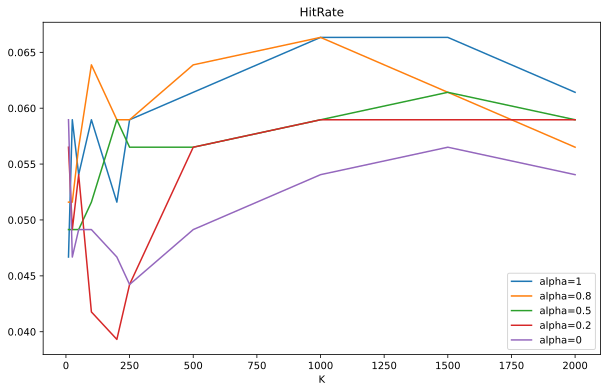

In [66]:
plt.plot(k_vals, knn_results[lambda x: x["alpha"]==1]["metric"], label='alpha=1')
plt.plot(k_vals, knn_results[lambda x: x["alpha"]==0.8]["metric"], label='alpha=0.8')
plt.plot(k_vals, knn_results[lambda x: x["alpha"]==0.5]["metric"], label='alpha=0.5')
plt.plot(k_vals, knn_results[lambda x: x["alpha"]==0.2]["metric"], label='alpha=0.2')
plt.plot(k_vals, knn_results[lambda x: x["alpha"]==0.0]["metric"], label='alpha=0')
plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("K")
plt.legend()

plt.show()

In [67]:
knn_results.sort_values('metric', ascending=False).head()

,alpha,k,metric
37,0.8,1000,0.066339
48,1.0,1500,0.066339
47,1.0,1000,0.066339
33,0.8,100,0.063882
36,0.8,500,0.063882


In [68]:
config = {
    'weights': True
}

results = uknn_gridsearch(k_vals, a_vals, config, trainval, testval, holdoutval, data_description, topn=20)

In [69]:
knn_results = pd.DataFrame(results)

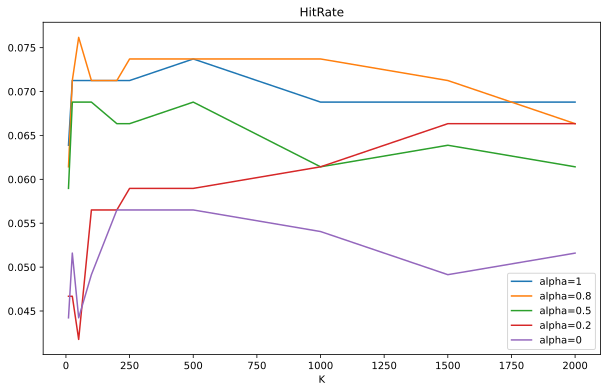

In [70]:
plt.plot(k_vals, knn_results[lambda x: x["alpha"]==1]["metric"], label='alpha=1')
plt.plot(k_vals, knn_results[lambda x: x["alpha"]==0.8]["metric"], label='alpha=0.8')
plt.plot(k_vals, knn_results[lambda x: x["alpha"]==0.5]["metric"], label='alpha=0.5')
plt.plot(k_vals, knn_results[lambda x: x["alpha"]==0.2]["metric"], label='alpha=0.2')
plt.plot(k_vals, knn_results[lambda x: x["alpha"]==0.0]["metric"], label='alpha=0')
plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("K")
plt.legend()

plt.show()

In [71]:
knn_results.sort_values('metric', ascending=False).head()

,alpha,k,metric
32,0.8,50,0.076167
46,1.0,500,0.073710
37,0.8,1000,0.073710
36,0.8,500,0.073710
35,0.8,250,0.073710


## Final Eval

In [46]:
train, test, holdout, data_index = reindex_all(_train, _test, _holdout)

In [47]:
data_description = {
    "n_users": train.userid.nunique(),
    "n_items": train.itemid.nunique(),
    "feedback": "rating",
    "weights": "weights",
    "items": "itemid",
    "users": "userid",
}

train = generate_weights(train, data_description)
test = generate_weights(test, data_description)

In [48]:
grand_total = []

In [49]:
def damped_mean(ratings):
    return sum(ratings) / (len(ratings) + 1024)

item2rating = train.groupby('itemid')["rating"].apply(damped_mean)
best_items = item2rating.nlargest(topn).index.values
popular_recs = np.ones((len(holdout), topn)) * best_items
metric = model_evaluate(popular_recs, holdout, data_description, topn)    

grand_total.append(
    {"method": "popularity", "metric": metric}
)

In [50]:
best_rank = 4
print("Best rank:", best_rank)

model = build_svd_model({"rank": best_rank}, train, data_description)
scores = svd_scoring(model, test, data_description)
svd_recs = topn_recommendations(scores, topn)

metric = model_evaluate(svd_recs, holdout, data_description, topn)

grand_total.append(
    {"method": "PureSVD", "metric": metric}
)

Best rank: 4
Interaction matrix shape: (5227, 3652)
Matrix density: 0.03799936340314036


In [51]:
best_config = {
    "rank": 4, "scaling": 0.9,
}
print(best_config)

model = build_scaled_svd_model(best_config, train, data_description)
scores = svd_scoring(model, test, data_description)
svd_recs = topn_recommendations(scores, topn)

metric = model_evaluate(svd_recs, holdout, data_description, topn)

grand_total.append(
    {"method": "ScaledSVD", "metric": metric}
)

{'rank': 4, 'scaling': 0.9}


In [52]:
best_config = {
    "rank": 4, 
    "sequence_similarity_coef": 0.25,
    "similarity_type": "cosine",
    "incomplete_cholesky_threshold": 0.03,
    "scaling": 0.1,
    "power": 0.75,
}
print(best_config)

model = build_seq_svd_model(best_config, train, data_description)
scores = svd_scoring(model, test, data_description)
svd_recs = topn_recommendations(scores, topn)

metric = model_evaluate(svd_recs, holdout, data_description, topn)

grand_total.append(
    {"method": "SeqSVD", "metric": metric}
)

{'rank': 4, 'sequence_similarity_coef': 0.25, 'similarity_type': 'cosine', 'incomplete_cholesky_threshold': 0.03, 'scaling': 0.1, 'power': 0.75}


In [53]:
best_config = {
    "alpha": 0.8,
    "k": 250,
    "weights": True,
    "similarity": "mixed"
}

model = build_uknn_model(best_config, train, data_description)
scores = uknn_scoring(model, test, data_description)
svd_recs = topn_recommendations(scores, topn)

metric = model_evaluate(svd_recs, holdout, data_description, topn)

grand_total.append(
    {"method": "JaccardUserKNN", "metric": metric}
)

In [54]:
pd.DataFrame(grand_total).sort_values("metric", ascending=False)

,method,metric
3,SeqSVD,0.118454
4,JaccardUserKNN,0.115960
1,PureSVD,0.100998
2,ScaledSVD,0.099751
0,popularity,0.051122
